This notebook contains the code for the descriptive statistics of _Timema_ orthologous groups (OGs), as well as a mean to export these.

# Settings

In [1]:
import glob
import collections
import numpy as np
from Bio import SeqIO
from itertools import repeat, product, chain
import matplotlib.pyplot as plt

In [2]:
wp = '../'
input_path = '{}input/'.format(wp)
output_path = '{}output/'.format(wp)
figures_path = '{}figures/'.format(wp)

In [3]:
# Timema genome and transcriptome identifiers 
gen_species = {'TPS', 'TDI', 'TCM', 'TSI', 'TCE', 'TMS', 'TBI', 'TTE', 'TGE', 'TPA'}
gen2trans_species = {x:"t{}".format(x) for x in gen_species}

colors = ["#7570b3", "#d95f02", "#1b9e77"]

# Functions

In [4]:
def get_orthodb_og2genes(cluster_file):
    '''
    Parse the output of OrthoDB standalone.
    '''
    og2genes = collections.defaultdict(list)
    with open(cluster_file, 'r') as inf:
        for line in inf:
            if line[0] == '#' or line[0] == '\n':
                pass
            else:
                og, gene = line.split()[:2]
                og2genes[int(og)].append(gene)
    return og2genes

def get_OG_species2genes(og, method, oma_id = True):
    '''
    Group genes by species within OGs.
    '''    
    OG_species2genes = None
    
    if method == "oma":
        if oma_id:
            OG_species2genes = {sp.name:list(map(lambda g: g.prot_id.split()[0], genes)) for sp, genes in og.get_all_descendant_genes_clustered_by_species().items()}
        else:
            OG_species2genes = {sp.name:list(map(lambda g: g.prot_id.split()[2], genes)) for sp, genes in og.get_all_descendant_genes_clustered_by_species().items()}
    
    elif method == "orthodb":
        OG_species2genes = collections.defaultdict(list)
        for g in og:
            OG_species2genes[g[:-5]].append(g)
        
    return OG_species2genes

def filter_OG_species2genes(OG_species2genes, OG_def, gen_species, gen2trans_species = None, trans_m2m = True):
    '''
    Filter genes from transcriptomes either completely (genomic definition) 
    or keeping them only in absence of gene from genomes (with_transcriptomic_genes definition).
    args:
    - OGtype_def: genomic or with_transcriptomic_genes
    - gen_species: set of genome identifiers
    - gen2trans_species: mappers from genome to transcriptome identifiers
    '''
    if OG_def == 'genomic':
        return {sp: genes for sp, genes in OG_species2genes.items() if sp in gen_species}

    elif OG_def == 'with_transcriptomic_genes':
        
        species2genes = dict()
        
        for sp in gen_species:
            genes = OG_species2genes.get(sp)

            # grab transcriptomic genes in absence of genomic ones
            if not genes:
                trans_genes = OG_species2genes.get(gen2trans_species[sp])

                if trans_m2m:
                    genes = trans_genes
                
                # grab only if trans genes has one copy...
                else:
                    if trans_genes and len(trans_genes) == 1:
                        genes = trans_genes
                    
            if genes:
                species2genes[sp] = genes
                
        return species2genes

def get_OGtype(og, OG_def, method, gen_species, gen2trans_species = None):
    '''
    From the gene set of an OG, determine its type (one-to-one vs. many-to-many).
    '''
    s2g = get_OG_species2genes(og, method)
    f_s2g = filter_OG_species2genes(s2g, OG_def, gen_species, gen2trans_species)
    
    og_type = '1to1' if len(f_s2g) == sum(list(map(len, f_s2g.values()))) else 'm2m'
    
    species_nr = len(f_s2g)
    
    return (og_type, species_nr), set(f_s2g.keys())

def get_OGtype_2_OGspecies_2_nr2OGnr(ogs, OG_def, method, gen_species, gen2trans_species):
    '''
    Compute the number of OGs for each possible species content (from 2 to 10), 
    while separating 1-to-1 from many-to-many OGs.
    '''
    OGtype_2_OGspecies_2_nr2OGnr = {'1to1': dict(zip(range(2, 11), repeat(0))),
                                    'm2m': dict(zip(range(2, 11), repeat(0)))}
    
    for og in ogs:
        og_type, og_species = get_OGtype(
            og, OG_def, method, gen_species, gen2trans_species)
        
        # ignore cases with < 2 species (e.g. copies from transcriptome and genomes)
        if og_type[1] >= 2:
            OGtype_2_OGspecies_2_nr2OGnr[og_type[0]][og_type[1]] += 1
    
    return OGtype_2_OGspecies_2_nr2OGnr

def plot_cum_OGnumber_per_OGspeciescontent_by_parametersetting(params, dict_list, colors, nr_species, max_og_nr, legend_loc=3, legend_fsize=8):
    '''
    Plot the cumulative number of OGs per OG species content.
    '''
    plt.rcParams.update({'font.size': 18})
    fig=plt.figure(figsize=(8, 6))

    # plot 1to1
    i = 0
    for i, p in enumerate(params):

        v = dict_list[i]['1to1'].values()     
        plt.plot(np.cumsum(list(v)[::-1])[::-1], label=p, marker='o',markersize=6, color=colors[i], linewidth=3)

        i += 1
    
    axes=plt.gca()
    axes.set_xlim([-0.5, nr_species - 1.5])
    axes.set_ylim([0, max_og_nr])
    
    plt.xticks(range(nr_species -1), ["≥{}".format(x) for x in range(2, nr_species + 2)])
    plt.xlabel('Species content')
    plt.ylabel('OG nr')
    plt.legend(loc=legend_loc, prop={'size': legend_fsize})
    plt.tight_layout()
    #plt.title("Cumulative OG number per OG species content\n by parameter setting")   
    plt.show()
    
    return fig

def get_species2gene_count(oma_proteomes_path):
    '''
    Use OMA splice files to count the number of gene per species.
    '''
    species2gene_count = {}
    
    splice_files = glob.glob("{}*.splice".format(oma_proteomes_path))

    for sf in splice_files:
        sp = sf.split('/')[-1].split('.')[0]
        
        with open(sf, 'r') as inf:
            species2gene_count[sp] = len(inf.readlines())
            
    return species2gene_count

def normalize_by_total_gene_nr(OGtype_2_species_2_OGspeciescount_2_GeneNr, gen_species, species2gene_count):
    '''
    Normalize by the number of gene in genome.
    '''
    # divide gene count by total number of genes
    OGtype_2_species_2_OGspeciescount_2_GeneFrac = {k:{sp:dict(zip(vv.keys(), [x / species2gene_count[sp] for x in vv.values()])) for sp, vv in v.items() if sp in gen_species} 
                                                            for k, v in OGtype_2_species_2_OGspeciescount_2_GeneNr.items()}  
    return OGtype_2_species_2_OGspeciescount_2_GeneFrac


def get_OGtype_2_species_2_OGspeciescount_2_GeneNr(ogs, OG_def, method, gen_species, gen2trans_species, species2gene_count):
    '''
    Compute, per species, the fraction of genes of each genome that belong to each combination of OG type (1-to-1 and m-to-m) and species content.
    '''
    OGtype_2_species_2_OGspeciescount_2_GeneNr = {'1to1':{sp:dict(zip(range(2,len(gen_species)+1), repeat(0))) for sp in gen_species},
                                                        'm2m':{sp:dict(zip(range(2,len(gen_species)+1), repeat(0))) for sp in gen_species}}
    
    # count the number of proteins part of OGs of various types and sizes by species
    for og in ogs:
                
        og_type, og_species = get_OGtype(og, OG_def, method, gen_species, gen2trans_species)
        
        # ignore cases with < 2 species (e.g. copies from transcriptome and genomes)
        if og_type[1] >= 2:
            
            for sp in og_species:
                OGtype_2_species_2_OGspeciescount_2_GeneNr[og_type[0]][sp][og_type[1]] += 1
    
    return normalize_by_total_gene_nr(OGtype_2_species_2_OGspeciescount_2_GeneNr, gen_species, species2gene_count)

def plot_mean_proteome_fraction_inside_OG_per_SpeciesContent_by_parameter_settings(params, dict_list, gen_species, colors, legend_loc=1, legend_fsize=18):
    '''
    Plot the cumalative mean gene fraction that belong to each combination of OG type (1-to-1 and m-to-m) and species content.
    '''
    plt.rcParams.update({'font.size': 18})
    fig=plt.figure(figsize=(8, 6))
    
    # max x axis
    max_species = len(gen_species)
    
    j = 0
    for i, p in enumerate(params):
        
        dd = dict_list[i]
        
        # 1to1
        sp_data = np.array([np.cumsum(np.array(list(x.values()))[::-1])[::-1] for x in dd['1to1'].values()]).T
        sp_mean = [np.mean(x) for x in sp_data]
        sp_sd = [np.std(x) for x in sp_data]
        plt.errorbar(np.arange(j, len(gen_species) -1 + j), sp_mean, yerr=sp_sd, label=p, color=colors[i], marker='o', markersize=6, linewidth=3)

        i += 1
        j += 0.025

    axes=plt.gca()
    axes.set_xlim([-0.5, max_species - 1.5])
    axes.set_ylim([0, 1.1])
    
    plt.xticks(range(max_species -1), ["≥{}".format(x) for x in range(2, max_species + 2)])
    plt.xlabel('Species content')
    plt.ylabel('Gene fraction')
    plt.legend(loc=legend_loc, prop={'size': legend_fsize})
    plt.tight_layout()
    plt.show()
    
    return fig

def oma_id_2_original_id_mapper(proteome_path, transcriptome_path):
    '''
    Mapper between temporary OMA ids and original ids in transcriptomes and genomes.
    '''
    oma_id_2_original_id = {}
    fastas_trans = glob.glob("{}*.fa".format(transcriptome_path))
    fastas_prots = glob.glob("{}*.fa".format(proteome_path))
    
    for f in fastas_prots:
        for rec in SeqIO.parse(f, format='fasta'):
            oma_id_2_original_id[rec.id] = rec.description[11:]

    for f in fastas_trans:
        for rec in SeqIO.parse(f, format='fasta'):
            oma_id_2_original_id[rec.id] = rec.description[12:]
            
    return oma_id_2_original_id

def write_og2_original_ids(ogs, mapper, og_classes, method, param, output_path, OG_def, genomic_species, taxon_gen2trans_species):
    '''
    Export OGs in TSV format where first column is the OG identifier and the second is the original id from transcriptome or genome.
    '''
    outlines = []
    i=1
    for og in ogs:

        s2g = get_OG_species2genes(og, method) 

        f_s2g = filter_OG_species2genes(s2g, OG_def, genomic_species, taxon_gen2trans_species)

        if (get_OGtype(og, OG_def, method, gen_species, gen2trans_species)[0]) in og_classes:#== og_class:
            outlines.extend(list(map(lambda x: '{} {}'.format(i, mapper[x]), list(chain(*f_s2g.values())))))
            i+=1
            
    with open("{}og2gene_{}_{}.txt".format(output_path, method, param), 'w') as outf:
        outf.write('\n'.join(outlines))

# Parse cluster file

In [5]:
# parse OrthoDB OGs
orthodb_cluster_fn = '{}AllAndPodura_WithTrans.og_remap'.format(input_path)
orthodb_og2genes = get_orthodb_og2genes(orthodb_cluster_fn)
orthodb_ogs = list(orthodb_og2genes.values())

# OG-centric statistics

In [6]:
orthodb_OGtype_2_OGspecies_2_nr2OGnr = get_OGtype_2_OGspecies_2_nr2OGnr(
    orthodb_ogs, 'genomic', 'orthodb', gen_species, gen2trans_species)

orthodb_wtranscripts_OGtype_2_OGspecies_2_nr2OGnr = get_OGtype_2_OGspecies_2_nr2OGnr(
    orthodb_ogs, 'with_transcriptomic_genes', 'orthodb', gen_species, gen2trans_species)

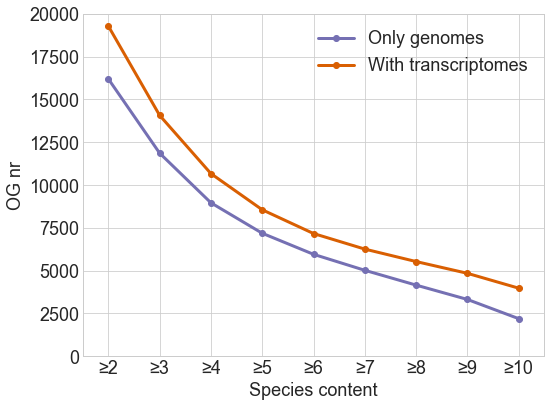

In [7]:
plt.style.use('seaborn-whitegrid')
fig = plot_cum_OGnumber_per_OGspeciescontent_by_parametersetting(
    ['Only genomes', 'With transcriptomes'], [orthodb_OGtype_2_OGspecies_2_nr2OGnr, orthodb_wtranscripts_OGtype_2_OGspecies_2_nr2OGnr],
    colors, 10, 20000, legend_loc=1, legend_fsize=18)
fig.savefig("{}OGnr.pdf".format(figures_path))

# Gene-centric statistics

In [8]:
oma_proteome_path = '{}oma_proteomes/'.format(input_path)
species2GeneNr = get_species2gene_count(oma_proteome_path)

orthodb_OGtype_2_species_2_OGspeciescount_2_GeneFrac = get_OGtype_2_species_2_OGspeciescount_2_GeneNr(
    orthodb_ogs, 'genomic', 'orthodb', gen_species, gen2trans_species, species2GeneNr)

orthodb_wtranscripts_OGtype_2_species_2_OGspeciescount_2_GeneFrac = get_OGtype_2_species_2_OGspeciescount_2_GeneNr(
    orthodb_ogs, 'with_transcriptomic_genes', 'orthodb', gen_species, gen2trans_species, species2GeneNr)

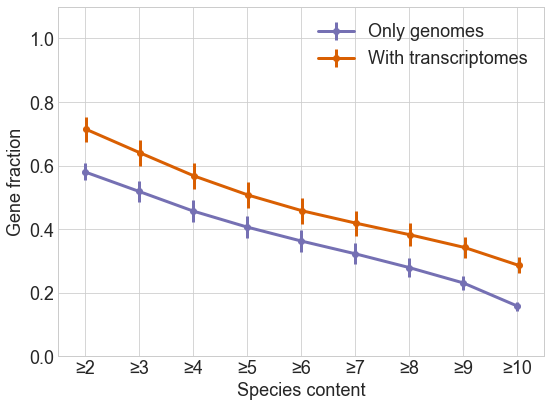

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plot_mean_proteome_fraction_inside_OG_per_SpeciesContent_by_parameter_settings(
    ['Only genomes', 'With transcriptomes'], [orthodb_OGtype_2_species_2_OGspeciescount_2_GeneFrac, orthodb_wtranscripts_OGtype_2_species_2_OGspeciescount_2_GeneFrac], 
    gen_species, colors)
fig.savefig("{}GeneFrac.pdf".format(figures_path))

# Export

In [10]:
oma_transcriptome_path = '{}oma_transcriptomes/'.format(input_path)
mapper = oma_id_2_original_id_mapper(oma_proteome_path, oma_transcriptome_path)

In [11]:
# define the classes to output
og_types = {'1to1', 'm2m'}
og_species_nr = range(2,11)
og_classes = list(product(og_types, og_species_nr))

In [12]:
write_og2_original_ids(
    orthodb_ogs, mapper, og_classes, "orthodb", 'wtranscripts', 
    output_path, "with_transcriptomic_genes", gen_species, gen2trans_species)